In [1]:
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")
# setup disply parameters
from matplotlib import pylab as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

float_formatter = StrMethodFormatter("{x:0.03f}")
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=(18, 6))  # set figure size
plt.rc("animation", html="html5")
import random

random.seed(203)
import numpy as np

np.random.seed(345)
from rich import print

In [2]:
from pathlib import Path

*The corresponding code for the tutorials can be found in the [ANL2025 Drive](https://drive.google.com/drive/folders/1xc5qt7XlZQQv6q1NVnu2vP6Ou-YOQUms?usp=drive_link) or at the ANL2025 Github repository.*

## Running a Multi-deal negotiation

ANL 2025's challenge is to develop agents capable of negotiating sequentially a set of interrelated deals (multi-deal negotiation). You can create and run a multi-deal negotiation using special tools provided by the anl2025 package. If you haven't read the call for participation yet, do it first [here](https://drive.google.com/drive/folders/1xc5qt7XlZQQv6q1NVnu2vP6Ou-YOQUms?usp=drive_link).

### An example multi-deal session: Target Quantity
We provide a set of test scenarios that you can download from the [ANL 2025 Google Drive](https://drive.google.com/drive/folders/1xc5qt7XlZQQv6q1NVnu2vP6Ou-YOQUms?usp=drive_link).

The following code shows how to load a scenario from a folder.  The scenario is called target quantity scenario, where a buyer wants to acquire a total of 10 from 4 different sellers.


In [3]:
from anl2025.scenario import MultidealScenario
import pathlib

path = pathlib.Path(
    "../../official_test_scenarios/TargetQuantity_example"
)  # You can also use a absolute path to the scenario here.
scenario = MultidealScenario.from_folder(path)

For running a negotiation, we don't just need a scenario: we also need negotiators! Therefore, we add some standard negotiators such as a `Random` .agent, a `Boulware` and a `Linear` conceder. We add a *center*  agent that negotiates with multiple opponents, and add the *edge agents*, the center agent's opponents.



In [4]:
from anl2025.negotiator import Boulware2025, Random2025, Linear2025

centeragent = Boulware2025
edgeagents = [
    Random2025,
    Random2025,
    Linear2025,
    Boulware2025,
]

Now the only thing we need to do to run a negotiation, is add this all together. The function `run_session` runs one sequential multi-deal negotiation. In ANL 2025, the center agent negotiates with the side agents sequentially. It completes a negotiation with one edge agent before starting the next negotiation with the next edge agent. At no time does the center agent have multiple negotiation threads running at the same time.

Behind the scenes, a lot of things happen in this small function. There are many parameters that you can change yourself, such as the center agent, edge agents and maximum number of rounds (`nsteps`). The function `run_session` automatically outputs logs of each thread, specifying what bid happened at what round. Moreover, it outputs a graph of the utilities of the center agent and the edge agents. By default, you can find this folder here **...\negmas\anl2025\session**.

Below, we show the outputted graphs. On the left, one can see the bids that were posed, with the utility of the center agent on the y-axis and the utility of the edge agent on the x-axis. The right figures show the bids over time, one for both agents.

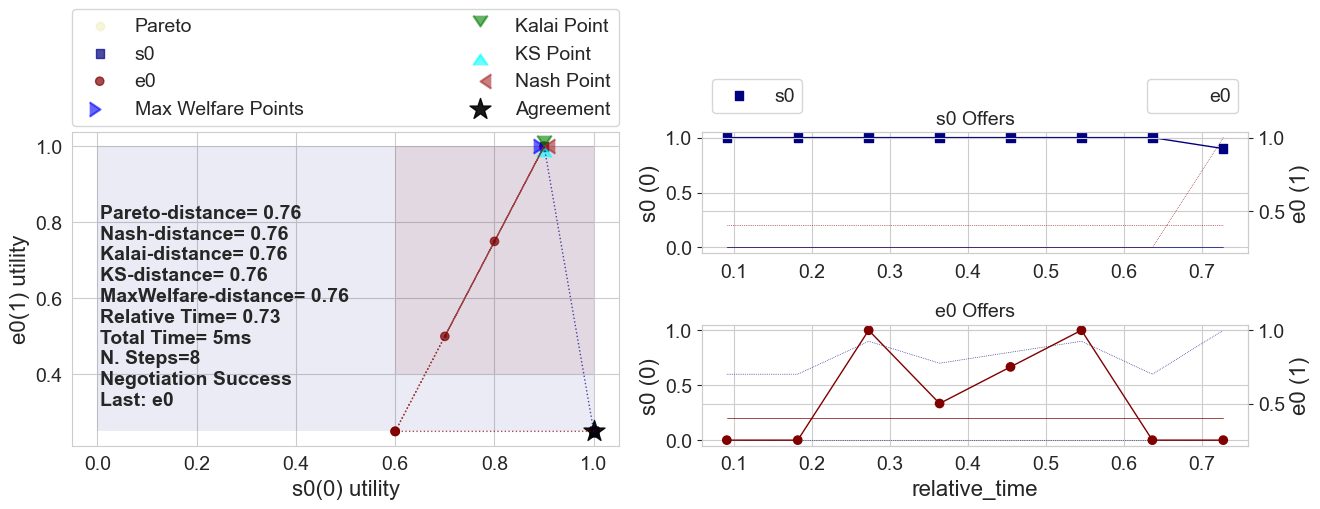

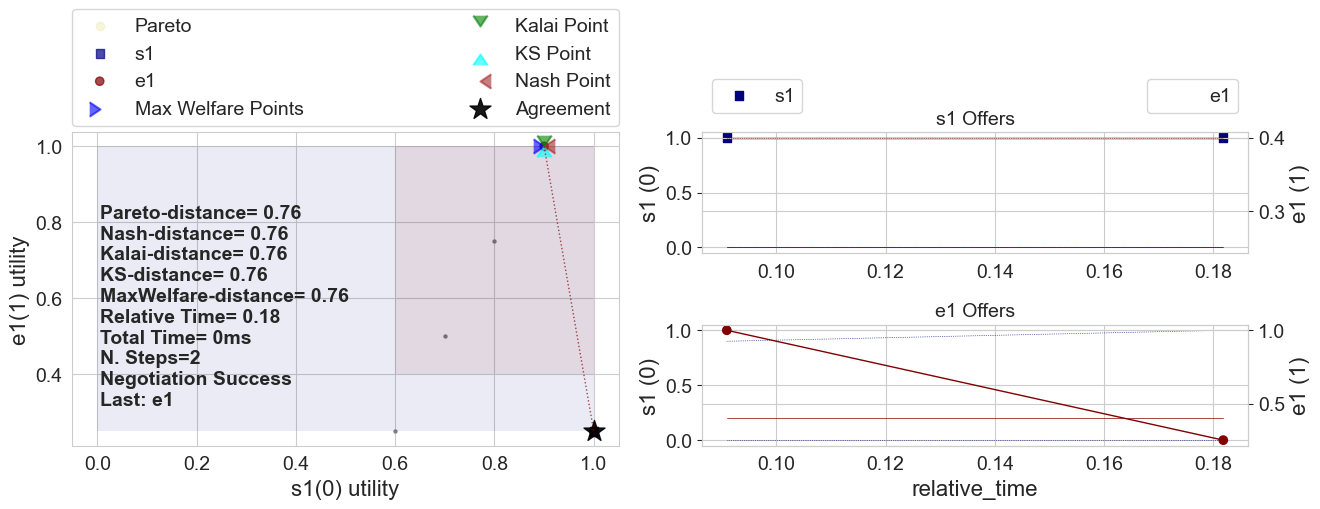

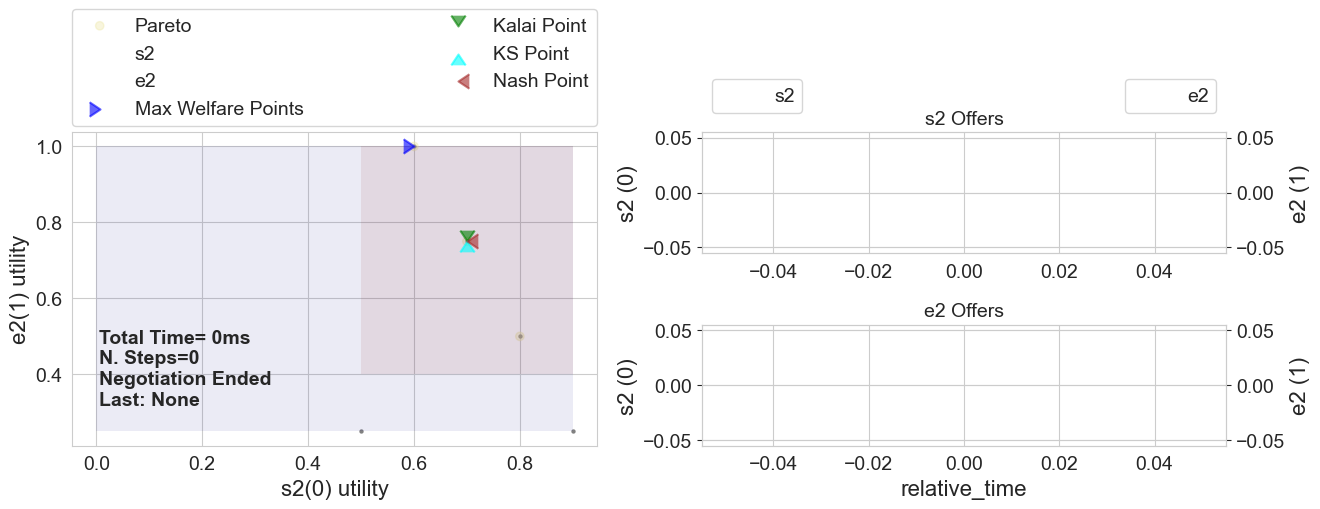

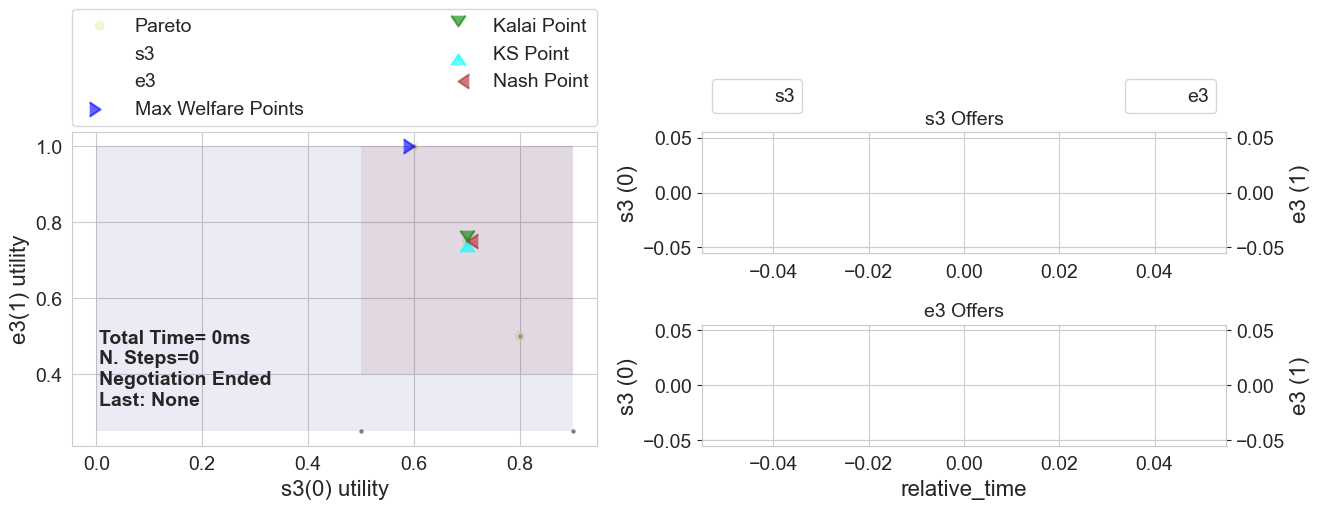

In [5]:
from anl2025 import run_session

results = run_session(
    scenario=scenario, center_type=centeragent, edge_types=edgeagents, nsteps=10
)

### Test the agent in a single session
The function `run_session` returns a `SessionResults` object, which allows you to access the following values after the session is completed:

1. `mechanisms` pointing to one [SAOMechanism](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAOMechanism.html#saomechanism) for each negotiation thread.
2. `center_negotiator` pointing to a [ANL2025Negotiator](reference/#anl2025.negotiator.ANL2025Negotiator) for the center negotiator.
3. `edge_negotiators` pointing to a list of [SAONegotiators](https://negmas.readthedocs.io/en/latest/api/negmas.sao.SAONegotiator.html#saonegotiator) for the edge negotiators.
4. `center_utility` giving the utility value received by the center negotiator
5. `edge_utility` giving the utility value received by each edge negotiator.You can also ask for specific types of output, by looking into `results`, e.g.:

In [6]:
print(f"Center utility: {results.center_utility}")
print(f"Edge Utilities: {results.edge_utilities}")
print(f"Agreement: {results.agreements}")

Center utility: 1.0

Edge Utilities: [0.25, 0.25, 0.4, 0.4]

Agreement: [('5',), ('5',), None, None]

These output possibilities also apply to the function `run_generated_session`, which runs a randomly generated session with some control over the types of negotiators for the center and edges as well as the utility functions used.


### Running a tournament
If you want to test the performance of multiple agents, you want to run more than one session, just like this competition will do. In the function `anl2025_tournament`, one can run a tournament that has similar parameters as the final competition.

We use a test scenario that we loaded before and a generated scenario. We log the final_scores, which is sum of the acquired utilities, and the weighted_average, which weighs the negotiations as center agent and as edge agent equally.



In [7]:
from anl2025 import anl2025_tournament, make_multideal_scenario

generated_scenario = make_multideal_scenario(nedges=3)
scenario = MultidealScenario.from_folder(path)
results = anl2025_tournament(
    scenarios=[scenario, generated_scenario],
    n_jobs=-1,
    competitors=(Random2025, Boulware2025, Linear2025),
    verbose=False,
    #  no_double_scores=False,
)

print(results.final_scores)
print(results.weighted_average)

Output()

Output()

{'Linear2025': 11.19060671023665, 'Boulware2025': 12.983114905251723, 'Random2025': 7.709687414076416}

{'Linear2025': 0.7513575922463772, 'Boulware2025': 0.8750449490212078, 'Random2025': 0.39032193059226045}

### A dinners' scheduling session

In the previous example, the center utility function was defined in terms of individual side utility functions (one per negotiation threads). A more general case is when the center utility function is defined directly in terms of the outcomes of negotiation threads without locally defined utility functions.

The `anl2025` package allows you to create such scenarios using the `LambdaCenterUFun` class (See Reference). One class of these scenarios is the **Dinners** scenarios in which one person (center agent) is negotiating with her friends (edge agents) about the day to go out for dinner. Each friend has her own utility function for different days. The center agent has a utility for each combination of agreements (i.e. she may prefer to go out once every night except in Tuesdays,

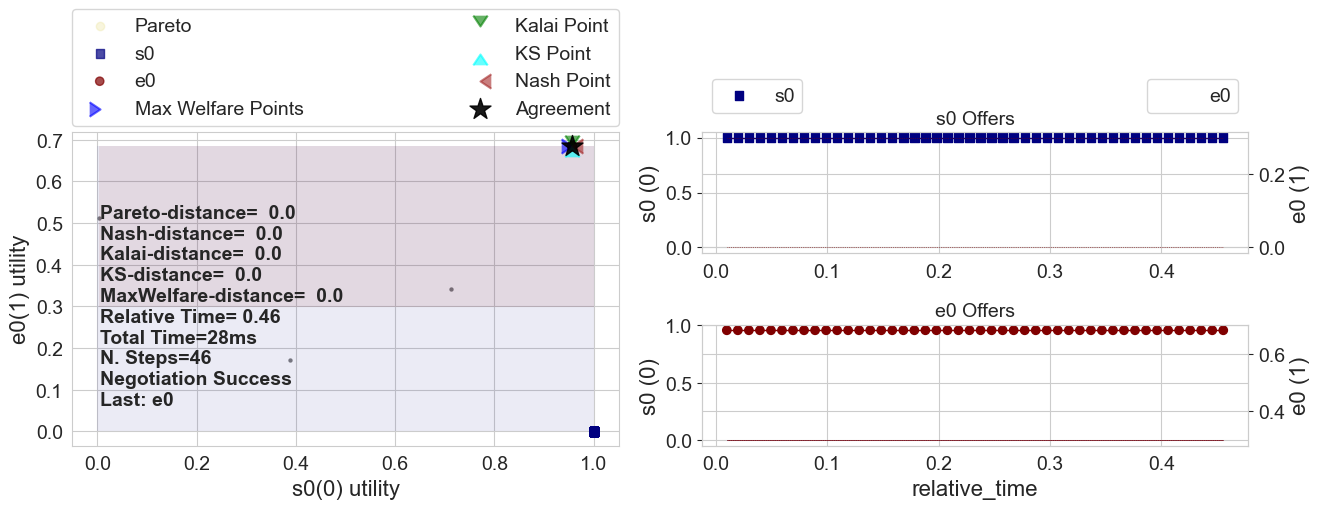

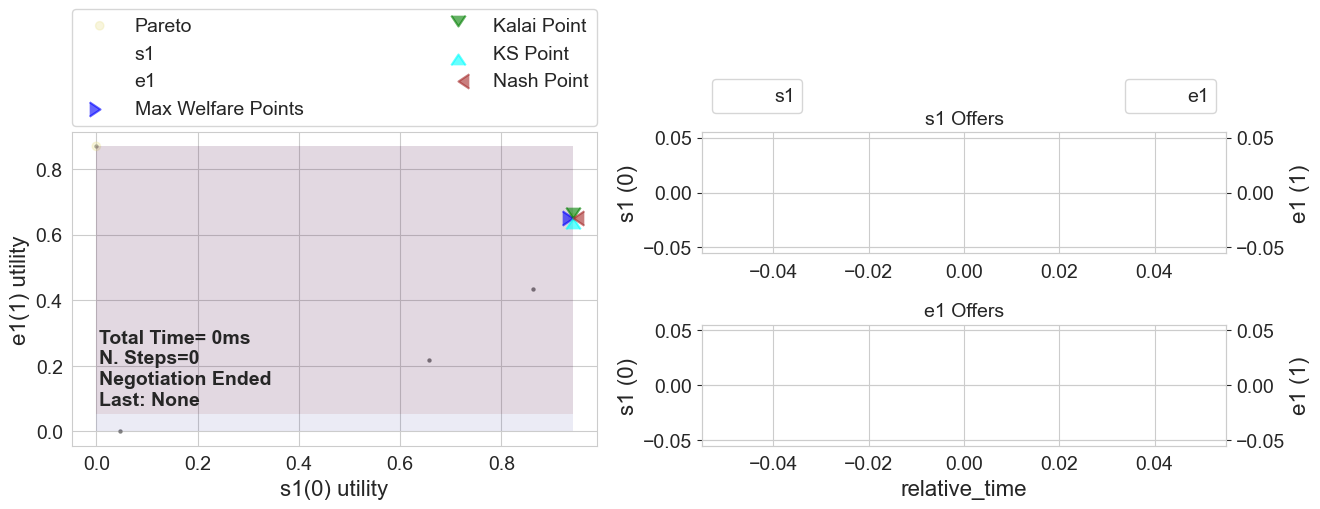

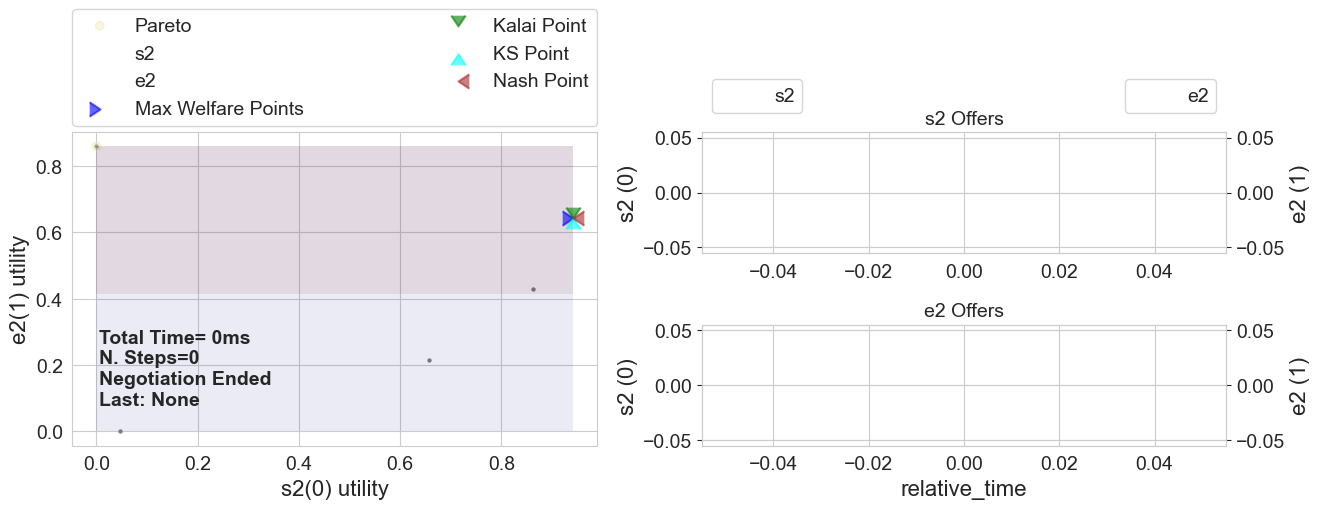

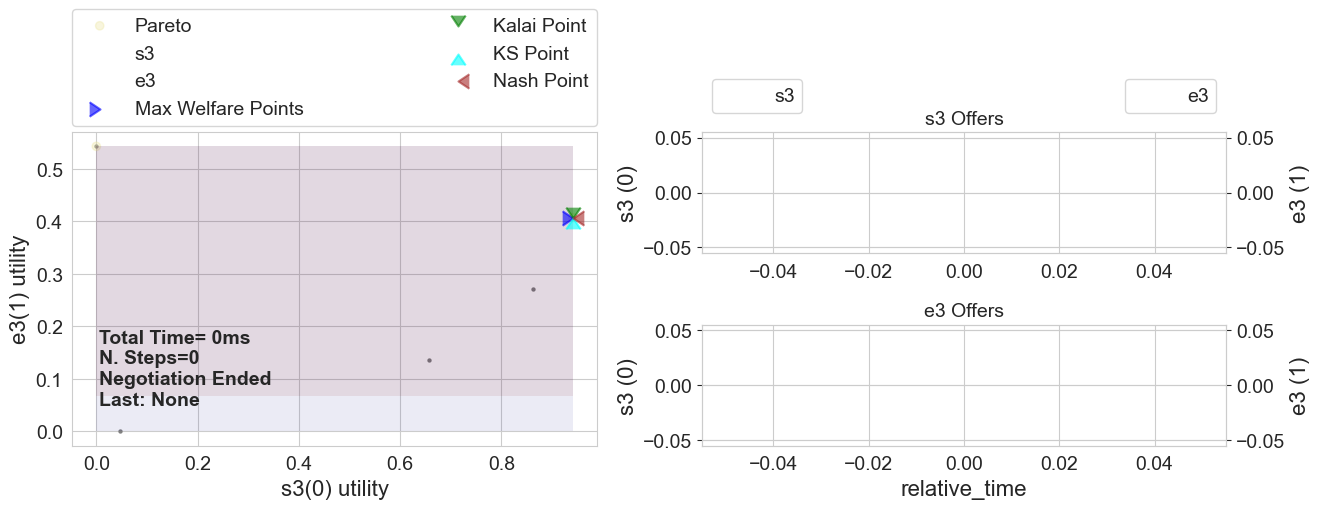

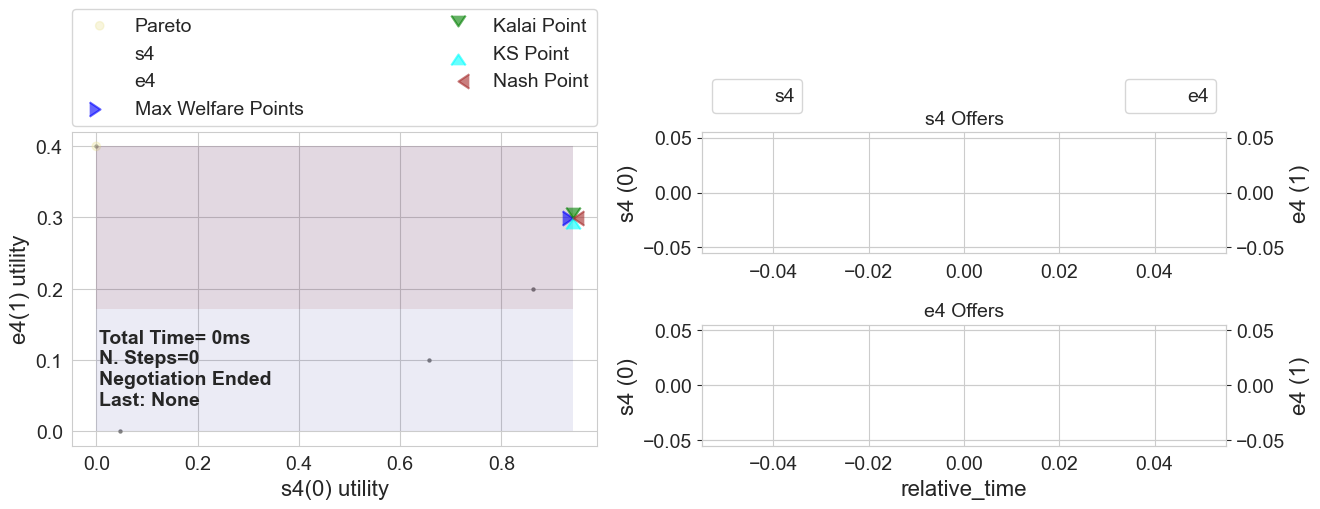

In [8]:
from anl2025 import make_dinners_scenario

results = run_session(make_dinners_scenario(n_friends=5))